<a href="https://colab.research.google.com/github/CoAxLab/ARS/blob/master/RaciallyBiasedDecisions/RaciallyBiasedDecisions_APF/behavioral/code/RBD_IAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
#@title Import libraries
import pandas as pd #for dealing with csv import
import os # for joining paths and filenames sensibly
import numpy as np #for the population std
import glob # for finding csv data files
import platform # paths use different dividers on linux vs windows, so we need to test for this
import string
import matplotlib.pyplot as plt

In [2]:
#@title Define Utility functions
#Compute adjusted mean
def adjustedmean(RTs,corrs,penalty):
    n=len(corrs) #trials
    n_errors=int(n-sum(corrs)) #errors
    # print("Number of correctness: ", int(sum(corrs)))
    # print("Number of errors: ", n_errors)
    cor_RTs=np.array(corrs)*RTs #sum of correct RTs
    cor_mean=sum(cor_RTs)/sum(corrs)

    #mean with errors replaced with penalty value
    return cor_mean+(n_errors*penalty)/n


#Remove timed out trials
def exclude_slows(RTs,corrs,slowRT_limit):
    new_rt=[] #holding variables
    new_cr=[]
    for i in range(len(RTs)): #iterate over every item
        if RTs[i] < slowRT_limit: #if it isn't too fast, include RT and corr values
            new_rt.append(RTs[i])
            new_cr.append(corrs[i])

    return (new_rt, new_cr)

#Compute IAT bias rating
def iat_analyze(congr_rts_raw, congr_corr_raw, incon_rts_raw, incon_corr_raw, df_name):
    #1 discard subject if too many fast responses
    if sum(np.array(np.concatenate((np.array(congr_rts_raw), np.array(incon_rts_raw))))<fastRT_limit)>len(np.concatenate((np.array(congr_rts_raw), np.array(incon_rts_raw))))*fast_prop_limit:
        print ("excluding subject for BM STR because too many fast responses")
    else:
        #2 Eliminate scores over 10,000 ms

        congr_rts,congr_corr=exclude_slows(congr_rts_raw,congr_corr_raw,slowRT_limit)
        incon_rts,incon_corr=exclude_slows(incon_rts_raw,incon_corr_raw,slowRT_limit)

        #3 Calculate pooled std
        #pooled_std=pooled.std(0) #n-1 std sample std
        #(Use N not N-1 because this is the whole sample).
        #numpy.std is population std
        pooled=congr_rts + incon_rts #all RTs from both blocks, correct and incorrect
        pooled_std=np.std(pooled)

        #4 Calculated adjusted means, including the penalty
        congr_adjmean=adjustedmean(congr_rts,congr_corr,penalty)
        incon_adjmean=adjustedmean(incon_rts,incon_corr,penalty)

        #5 Calculate the IAT, so that pro-stereotype RTs are a -ve score
        IAT=(congr_adjmean-incon_adjmean)/pooled_std

        simpleIAT=sum(congr_rts)/len(congr_rts)-sum(incon_rts)/len(incon_rts)

        return(IAT)
        print("IAT for " + df_name + " is : {:+.3f}".format(IAT))
        print("Mean difference (uncorrected) " + df_name + " is {:+.3f}".format(simpleIAT)+" seconds")

In [3]:
#@title Load data
df_IAT_BM = pd.read_csv ('https://github.com/ExCaLBBR/ExCaLBBR_Projects/raw/main/RaciallyBiasedDecisions/RaciallyBiasedDecisions-Intersectionality_SURG/data/IAT_BM.csv', header=0)
df_IAT_WM = pd.read_csv ('https://github.com/ExCaLBBR/ExCaLBBR_Projects/raw/main/RaciallyBiasedDecisions/RaciallyBiasedDecisions-Intersectionality_SURG/data/IAT_WM.csv', header=0)

In [4]:
#@title Specify thresholds
penalty=0.600 #penalty - in seconds - for incorrect responses
slowRT_limit=10000 #threshold at which slow RTs are discarded
fastRT_limit=300 #threshold which defines responses which are "too fast"
fast_prop_limit=0.1 # threshold proportion of "too fast" responses which defines exclusion of ppt


In [5]:
#@title Data Extraction
df_IAT_BM.rename(columns={"Spreadsheet: metadata": "Congruence", "allocator-k3xu": "Group Type"}, inplace = True)
df_IAT_BM_2 = df_IAT_BM.drop(["Spreadsheet: ImageLeft", "Spreadsheet: ImageRight"], axis = 1)
df_IAT_WM.rename(columns={"Spreadsheet: metadata": "Congruence", "allocator-k3xu": "Group Type"}, inplace = True)
df_IAT_WM_2 = df_IAT_WM.drop(["Spreadsheet: ImageLeft", "Spreadsheet: ImageRight"], axis = 1)

#Isolate columns based on stereotype category which are not part of the practice blocks
df_IAT_BM_STR = df_IAT_BM_2[((df_IAT_BM_2["Spreadsheet: TextLeft"] == "Strong") | (df_IAT_BM_2["Spreadsheet: TextRight"] == "Strong")) & (~df_IAT_BM_2["Congruence"].str.startswith("practice"))]
df_IAT_BM_INT = df_IAT_BM_2[((df_IAT_BM_2["Spreadsheet: TextLeft"] == "Intelligence") | (df_IAT_BM_2["Spreadsheet: TextRight"] == "Intelligence")) & (~df_IAT_BM_2["Congruence"].str.startswith("practice"))]
df_IAT_WM_STR = df_IAT_WM_2[((df_IAT_WM_2["Spreadsheet: TextLeft"] == "Strong") | (df_IAT_WM_2["Spreadsheet: TextRight"] == "Strong")) & (~df_IAT_WM_2["Congruence"].str.startswith("practice"))]
df_IAT_WM_INT = df_IAT_WM_2[((df_IAT_WM_2["Spreadsheet: TextLeft"] == "Intelligence") | (df_IAT_WM_2["Spreadsheet: TextRight"] == "Intelligence")) & (~df_IAT_WM_2["Congruence"].str.startswith("practice"))]

# BM STR lists RV: polarity of the condition was mislabed in the original data and is corrected here
congr_BM_STR_ID = df_IAT_BM_STR[df_IAT_BM_STR["Congruence"] == "incongruent"]["Participant Private ID"].dropna().tolist()
congr_corr_BM_STR = df_IAT_BM_STR[df_IAT_BM_STR["Congruence"] == "incongruent"]["Correct"].dropna().tolist()
congr_rts_BM_STR = df_IAT_BM_STR[df_IAT_BM_STR["Congruence"] == "incongruent"]["Absolute Reaction Time"].dropna().tolist()
incon_BM_STR_ID = df_IAT_BM_STR[df_IAT_BM_STR["Congruence"] == "congruent"]["Participant Private ID"].dropna().tolist()
incon_corr_BM_STR = df_IAT_BM_STR[df_IAT_BM_STR["Congruence"] == "congruent"]["Correct"].dropna().tolist()
incon_rts_BM_STR = df_IAT_BM_STR[df_IAT_BM_STR["Congruence"] == "congruent"]["Absolute Reaction Time"].dropna().tolist()
# BM INT lists
congr_BM_INT_ID = df_IAT_BM_INT[df_IAT_BM_INT["Congruence"] == "congruent"]["Participant Private ID"].dropna().tolist()
congr_corr_BM_INT = df_IAT_BM_INT[df_IAT_BM_INT["Congruence"] == "congruent"]["Correct"].dropna().tolist()
congr_rts_BM_INT = df_IAT_BM_INT[df_IAT_BM_INT["Congruence"] == "congruent"]["Absolute Reaction Time"].dropna().tolist()
incon_BM_INT_ID = df_IAT_BM_INT[df_IAT_BM_INT["Congruence"] == "incongruent"]["Participant Private ID"].dropna().tolist()
incon_corr_BM_INT = df_IAT_BM_INT[df_IAT_BM_INT["Congruence"] == "incongruent"]["Correct"].dropna().tolist()
incon_rts_BM_INT = df_IAT_BM_INT[df_IAT_BM_INT["Congruence"] == "incongruent"]["Absolute Reaction Time"].dropna().tolist()
# WM STR lists RV: polarity of the condition was mislabed in the original data and is corrected here
congr_WM_STR_ID = df_IAT_WM_STR[df_IAT_WM_STR["Congruence"] == "incongruent"]["Participant Private ID"].dropna().tolist()
congr_corr_WM_STR = df_IAT_WM_STR[df_IAT_WM_STR["Congruence"] == "incongruent"]["Correct"].dropna().tolist()
congr_rts_WM_STR = df_IAT_WM_STR[df_IAT_WM_STR["Congruence"] == "incongruent"]["Absolute Reaction Time"].dropna().tolist()
incon_WM_STR_ID = df_IAT_WM_STR[df_IAT_WM_STR["Congruence"] == "congruent"]["Participant Private ID"].dropna().tolist()
incon_corr_WM_STR = df_IAT_WM_STR[df_IAT_WM_STR["Congruence"] == "congruent"]["Correct"].dropna().tolist()
incon_rts_WM_STR = df_IAT_WM_STR[df_IAT_WM_STR["Congruence"] == "congruent"]["Absolute Reaction Time"].dropna().tolist()
# WM INT lists
congr_WM_INT_ID = df_IAT_WM_INT[df_IAT_WM_INT["Congruence"] == "congruent"]["Participant Private ID"].dropna().tolist()
congr_corr_WM_INT = df_IAT_WM_INT[df_IAT_WM_INT["Congruence"] == "congruent"]["Correct"].dropna().tolist()
congr_rts_WM_INT = df_IAT_WM_INT[df_IAT_WM_INT["Congruence"] == "congruent"]["Absolute Reaction Time"].dropna().tolist()
incon_WM_INT_ID = df_IAT_WM_INT[df_IAT_WM_INT["Congruence"] == "incongruent"]["Participant Private ID"].dropna().tolist()
incon_corr_WM_INT = df_IAT_WM_INT[df_IAT_WM_INT["Congruence"] == "incongruent"]["Correct"].dropna().tolist()
incon_rts_WM_INT = df_IAT_WM_INT[df_IAT_WM_INT["Congruence"] == "incongruent"]["Absolute Reaction Time"].dropna().tolist()
# check correctness list has the same length as the rt list
# print(len(congr_corr_BM_STR))
# print(len(congr_rts_BM_STR))


In [7]:
#@title Filter participants who are too fast
#Find and remove participants who are too fast
BM_ID = np.unique(congr_BM_STR_ID)
remIndx = []
for p in range(len(BM_ID)):
    indx_cong = np.where(np.array(congr_BM_STR_ID) == BM_ID[p])
    indx_incon = np.where(np.array(incon_BM_STR_ID) == BM_ID[p])
    if sum(np.array(np.concatenate((np.array(congr_rts_BM_STR)[indx_cong], np.array(incon_rts_BM_STR)[indx_incon])))<fastRT_limit)>len(np.concatenate((np.array(congr_rts_BM_STR)[indx_cong], np.array(incon_rts_BM_STR)[indx_incon])))*fast_prop_limit:
      print ("Excluding subject", BM_ID[p], "for BM STR because too many fast responses")
      remIndx.append(p)
BM_ID_filt = np.delete(BM_ID, remIndx)
# BM Intelligence
remIndx = []
for p in range(len(BM_ID_filt)):
    indx_cong = np.where(np.array(congr_BM_INT_ID) == BM_ID_filt[p])
    indx_incon = np.where(np.array(incon_BM_INT_ID) == BM_ID_filt[p])
    if sum(np.array(np.concatenate((np.array(congr_rts_BM_INT)[indx_cong], np.array(incon_rts_BM_INT)[indx_incon])))<fastRT_limit)>len(np.concatenate((np.array(congr_rts_BM_INT)[indx_cong], np.array(incon_rts_BM_INT)[indx_incon])))*fast_prop_limit:
      print ("Excluding subject", BM_ID_filt[p], "for BM INT because too many fast responses")
      remIndx.append(p)
BM_ID_filt = np.delete(BM_ID_filt, remIndx)

# White Male Strength
WM_ID = np.unique(congr_WM_STR_ID)
remIndx = []
for p in range(len(WM_ID)):
    indx_cong = np.where(np.array(congr_WM_STR_ID) == WM_ID[p])
    indx_incon = np.where(np.array(incon_WM_STR_ID) == WM_ID[p])
    if sum(np.array(np.concatenate((np.array(congr_rts_WM_STR)[indx_cong], np.array(incon_rts_WM_STR)[indx_incon])))<fastRT_limit)>len(np.concatenate((np.array(congr_rts_WM_STR)[indx_cong], np.array(incon_rts_WM_STR)[indx_incon])))*fast_prop_limit:
      print ("Excluding subject", WM_ID[p], "for WM STR because too many fast responses")
      remIndx.append(p)
WM_ID_filt = np.delete(WM_ID, remIndx)
# White Male Intel
remIndx = []
for p in range(len(WM_ID_filt)):
    indx_cong = np.where(np.array(congr_WM_INT_ID) == WM_ID_filt[p])
    indx_incon = np.where(np.array(incon_WM_INT_ID) == WM_ID_filt[p])
    if sum(np.array(np.concatenate((np.array(congr_rts_WM_INT)[indx_cong], np.array(incon_rts_WM_INT)[indx_incon])))<fastRT_limit)>len(np.concatenate((np.array(congr_rts_WM_INT)[indx_cong], np.array(incon_rts_WM_INT)[indx_incon])))*fast_prop_limit:
      print ("Excluding subject", WM_ID_filt[p], "for WM INT because too many fast responses")
      remIndx.append(p)
WM_ID_filt = np.delete(WM_ID_filt, remIndx)


Excluding subject 8657542.0 for BM STR because too many fast responses
Excluding subject 8657619.0 for BM STR because too many fast responses
Excluding subject 8657695.0 for BM STR because too many fast responses
Excluding subject 8657698.0 for BM STR because too many fast responses
Excluding subject 8660226.0 for BM STR because too many fast responses
Excluding subject 8663169.0 for BM STR because too many fast responses
Excluding subject 8657248.0 for BM INT because too many fast responses
Excluding subject 8657280.0 for WM STR because too many fast responses
Excluding subject 8657313.0 for WM STR because too many fast responses
Excluding subject 8657329.0 for WM STR because too many fast responses
Excluding subject 8657334.0 for WM STR because too many fast responses
Excluding subject 8657343.0 for WM STR because too many fast responses
Excluding subject 8657323.0 for WM INT because too many fast responses


In [16]:
#@title Compute IAT bias
# Black Male Strength
BM_IAT_STR = []
for p in range(len(BM_ID_filt)):
  indx_cong = np.where(np.array(congr_BM_STR_ID) == BM_ID_filt[p])[0]
  cong_corr_BM_STR_pi = np.array(congr_corr_BM_STR)[indx_cong]
  cong_rts_BM_STR_pi = np.array(congr_rts_BM_STR)[indx_cong]
  indx_incon = np.where(np.array(incon_BM_STR_ID) == BM_ID_filt[p])[0]
  incon_corr_BM_STR_pi = np.array(incon_corr_BM_STR)[indx_incon]
  incon_rts_BM_STR_pi = np.array(incon_rts_BM_STR)[indx_incon]
  #print(BM_ID_filt[p])
  iatBias = iat_analyze(cong_rts_BM_STR_pi, cong_corr_BM_STR_pi, incon_rts_BM_STR_pi, incon_corr_BM_STR_pi, "BM STR")
  BM_IAT_STR.append(iatBias)

# Black Male Intel
BM_IAT_INT = []
for p in range(len(BM_ID_filt)):
  indx_cong = np.where(np.array(congr_BM_INT_ID) == BM_ID_filt[p])[0]
  cong_corr_BM_INT_pi = np.array(congr_corr_BM_INT)[indx_cong]
  cong_rts_BM_INT_pi = np.array(congr_rts_BM_INT)[indx_cong]
  indx_incon = np.where(np.array(incon_BM_INT_ID) == BM_ID_filt[p])[0]
  incon_corr_BM_INT_pi = np.array(incon_corr_BM_INT)[indx_incon]
  incon_rts_BM_INT_pi = np.array(incon_rts_BM_INT)[indx_incon]
  #print(BM_ID_filt[p])
  iatBias = iat_analyze(cong_rts_BM_INT_pi, cong_corr_BM_INT_pi, incon_rts_BM_INT_pi, incon_corr_BM_INT_pi, "BM INT")
  BM_IAT_INT.append(iatBias)

# White Male Strength
WM_IAT_STR = []
for p in range(len(WM_ID_filt)):
  indx_cong = np.where(np.array(congr_WM_STR_ID) == WM_ID_filt[p])[0]
  cong_corr_WM_STR_pi = np.array(congr_corr_WM_STR)[indx_cong]
  cong_rts_WM_STR_pi = np.array(congr_rts_WM_STR)[indx_cong]
  indx_incon = np.where(np.array(incon_WM_STR_ID) == WM_ID_filt[p])[0]
  incon_corr_WM_STR_pi = np.array(incon_corr_WM_STR)[indx_incon]
  incon_rts_WM_STR_pi = np.array(incon_rts_WM_STR)[indx_incon]
  #print(WM_ID_filt[p])
  iatBias = iat_analyze(cong_rts_WM_STR_pi, cong_corr_WM_STR_pi, incon_rts_WM_STR_pi, incon_corr_WM_STR_pi, "WM STR")
  WM_IAT_STR.append(iatBias)

# White Male Intel
WM_IAT_INT = []
for p in range(len(WM_ID_filt)):
  indx_cong = np.where(np.array(congr_WM_INT_ID) == WM_ID_filt[p])[0]
  cong_corr_WM_INT_pi = np.array(congr_corr_WM_INT)[indx_cong]
  cong_rts_WM_INT_pi = np.array(congr_rts_WM_INT)[indx_cong]
  indx_incon = np.where(np.array(incon_WM_INT_ID) == WM_ID_filt[p])[0]
  incon_corr_WM_INT_pi = np.array(incon_corr_WM_INT)[indx_incon]
  incon_rts_WM_INT_pi = np.array(incon_rts_WM_INT)[indx_incon]
  #print(WM_ID_filt[p])
  iatBias = iat_analyze(cong_rts_WM_INT_pi, cong_corr_WM_INT_pi, incon_rts_WM_INT_pi, incon_corr_WM_INT_pi, "WM INT")
  WM_IAT_INT.append(iatBias)

TypeError: ignored

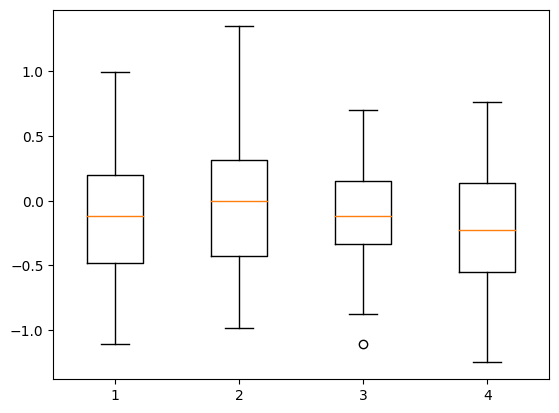

In [37]:
Combined_IAT = [BM_IAT_STR, BM_IAT_INT, WM_IAT_STR, WM_IAT_INT]
Combined_IAT_bp = plt.boxplot(Combined_IAT)
bp_labels = ['BM_IAT_STR', 'BM_IAT_INT','WM_IAT_STR', 'WM_IAT_INT']
plt.gca(Combined_IAT_bp).set_xticklabels(bp_labels)

In [9]:
#@title Participant-wise analysis of IAT bias by Stereotype category

#Group by stereotype means
BM_IAT_STR_Avg = np.mean(BM_IAT_STR)*-1
BM_IAT_INT_Avg = np.mean(BM_IAT_INT)*-1
WM_IAT_STR_Avg = np.mean(WM_IAT_STR)*-1
WM_IAT_INT_Avg = np.mean(WM_IAT_INT)*-1

#Group by stereotype standard deviation
BM_IAT_STR_SD = np.std(BM_IAT_STR)
BM_IAT_INT_SD = np.std(BM_IAT_INT)
WM_IAT_STR_SD = np.std(WM_IAT_STR)
WM_IAT_INT_SD = np.std(WM_IAT_INT)


#Print output
print("Black Male Strength Stereotype IAT bias =", BM_IAT_STR_Avg, "(SD = ", BM_IAT_STR_SD, ")")
print("Black Male Intelligence Stereotype IAT bias =", BM_IAT_INT_Avg, "(SD = ", BM_IAT_INT_SD, ")")
print("White Male Strength Stereotype IAT bias =", WM_IAT_STR_Avg, "(SD = ", WM_IAT_STR_SD, ")")
print("White Male Intelligence Stereotype IAT bias =", WM_IAT_INT_Avg, "(SD = ", WM_IAT_INT_SD, ")")

Black Male Strength Stereotype IAT bias = 0.13536111271726628 (SD =  0.4674800833135985 )
Black Male Intelligence Stereotype IAT bias = 0.02154126859389521 (SD =  0.47415817247147524 )
White Male Strength Stereotype IAT bias = 0.09968998227057914 (SD =  0.3944171588604764 )
White Male Intelligence Stereotype IAT bias = 0.19912697388866202 (SD =  0.4743921521324688 )


In [10]:
#Groupwise Analysis
# iat_analyze(congr_rts_BM_STR, congr_corr_BM_STR, incon_rts_BM_STR, incon_corr_BM_STR, "BM STR")
# iat_analyze(congr_rts_BM_INT, congr_corr_BM_INT, incon_rts_BM_INT, incon_corr_BM_INT, "BM INT")
# iat_analyze(congr_rts_WM_STR, congr_corr_WM_STR, incon_rts_WM_STR, incon_corr_WM_STR, "WM STR")
# iat_analyze(congr_rts_WM_INT, congr_corr_WM_INT, incon_rts_WM_INT, incon_corr_WM_INT, "WM INT")

## Reference:
IAT data analysis script adapted from https://github.com/tomstafford/IAT

Calculate IAT score from data generated by Robin's PsychoPy script [TQS Feb 2014]

*Greenwald, A. G., Nosek, B. A., & Banaji, M. R. (2003). Understanding and using the implicit association test: I. An improved scoring algorithm. Journal of personality and social psychology, 85(2), 1972-216.*